# PROJEKT WUM 2

### Potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

Na moodle'u są pliki z wykresami, gdyby nie działały. Niestety nie są ładne, przepraszam ;(

### Pobieranie danych

In [2]:
!pip install --upgrade gdown

In [3]:
!gdown https://drive.google.com/uc?id=1IV7Q1JWBO-HvMcEjrslaAms4uFnfuHuI
!gdown https://drive.google.com/uc?id=1MA-QTcKrRn9wU3EBekDbyHL-QwzjUM5n
!gdown https://drive.google.com/uc?id=1_5Kq8LWAYD3RXyphGvT4J0H6qXuiJ5qm

Downloading...
From (original): https://drive.google.com/uc?id=1IV7Q1JWBO-HvMcEjrslaAms4uFnfuHuI
From (redirected): https://drive.google.com/uc?id=1IV7Q1JWBO-HvMcEjrslaAms4uFnfuHuI&confirm=t&uuid=9127ae93-3207-4ce3-bcf3-c70c6432cfa5
To: C:\Users\Julek\PycharmProjects\pythonProject4\X_train.csv

  0%|          | 0.00/188M [00:00<?, ?B/s]
  1%|          | 1.05M/188M [00:00<00:21, 8.88MB/s]
  2%|1         | 3.15M/188M [00:00<00:13, 13.5MB/s]
  3%|2         | 5.24M/188M [00:00<00:12, 15.1MB/s]
  4%|3         | 7.34M/188M [00:00<00:10, 16.6MB/s]
  5%|5         | 9.44M/188M [00:00<00:10, 17.3MB/s]
  6%|6         | 11.5M/188M [00:00<00:10, 17.1MB/s]
  7%|7         | 13.6M/188M [00:00<00:09, 17.5MB/s]
  8%|8         | 15.7M/188M [00:00<00:10, 16.8MB/s]
  9%|9         | 17.8M/188M [00:01<00:10, 15.8MB/s]
 11%|#         | 19.9M/188M [00:01<00:09, 16.9MB/s]
 12%|#1        | 22.0M/188M [00:01<00:09, 16.6MB/s]
 13%|#2        | 24.1M/188M [00:01<00:10, 15.0MB/s]
 14%|#3        | 26.2M/188M [00:01<00

Zacznę od zapisania danych w postaci dataframe'u.

In [15]:
xtrain = pd.read_csv('X_train.csv')
ytrain = pd.read_csv('y_train.csv')
xtest = pd.read_csv('X_test.csv')

# Analiza danych:

### Zbiór objaśniający:

In [16]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9001 entries, LINC01409 to AL592183.1
dtypes: float64(9001)
memory usage: 260.5 MB


Liczba zmiennych opisujących jest równa 9001, a samych obserwacji jest 3794. Wszystkie dane są typu numerycznego, więc nie trzeba ich konwertować. Warto jednak upewnić się, czy nie ma luk w danych.

In [17]:
print("Brak luk w xtrain:", not xtrain.isnull().values.any())

Brak luk w xtrain: True


### Zbiór objaśniany:

In [18]:
ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB


Liczba zmiennych to 2, jednak jedna z nich, to ID, które oczywiście można pominąć. Liczba wierszy jest równa 3794, co odpowiada liczbie obserwacji. Wszystkie dane mają typ numeryczny, a funkcja info przy okazji pokazuje brak luk.

### Zbiór testowy:

In [19]:
xtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9001 entries, LINC01409 to AL592183.1
dtypes: float64(9001)
memory usage: 46.0 MB


Liczba zmiennych w xtest jest równa liczbie zmiennych w xtrain, czyli 9001. Obserwacji jest 670 i wszystkie dane mają typ numeryczny. Ponownie warto sprawdzić, czy nie ma luk.

In [20]:
print("Brak luk w xtest:", not xtest.isnull().values.any())

Brak luk w xtest: True


Usunę zmienne, których wartość dla wszystkich obserwacji jest identyczna, ponieważ nie wpływają one w żadnym stopniu na model.

In [21]:
licznik = 0
for col in xtrain.columns:
    if (xtrain[col] == xtrain[col].iloc[0]).all():
        xtrain.drop(labels=col, axis=1, inplace=True)
        xtest.drop(labels=col, axis=1, inplace=True)
        licznik = licznik + 1
print("Ilość wyrzuconych zmiennych:", licznik)

Ilość wyrzuconych zmiennych: 1


Jak widać, usunięta została tylko jedna zmienna.

# Rozkład empiryczny zmiennej objaśnianej:


In [22]:
ytrain = ytrain['Expected']
ytrain.describe()

count    3794.000000
mean        1.143673
std         0.770174
min         0.000000
25%         0.296568
50%         1.404803
75%         1.783414
max         2.627595
Name: Expected, dtype: float64

In [98]:
px.histogram(ytrain).show()

Zmienna objaśniana dla bardzo wielu obserwacji ma wartość 0 (prawie 1/4). Przez dominację 0, wartości statystk mogą być dość zakłócone. Histogram nie ukazuje żadengo konkretnego rozkładu empirycznego.

# Korelacje

### Wybór 250 najbardziej skorelowanych zmiennych objaśniających:

Pomimo braku spełnionych załóżeń (nie sprawdzam chociażby, czy zmienne mają rozkład normalny, ponieważ jest ich zbyt dużo i ciężko by było transformować dane) używam współczynnika korelacji Spearmana, ponieważ zmienne niekoniecznie mają rozkład normalny. Na obliczoną wartość zarówno wyłaniając najbardziej skorelowane zmienne jak i przy rysowaniu mapy ciepła, nakładam wartość bezwzględną, ponieważ interesuje mnie jak mocno zmienne są skorelowane, a nie dokładna wartość.

In [55]:
corrs = []
for col in xtrain.columns:
  spearman = spearmanr(ytrain, xtrain[col])
  corrs.append([abs(spearman[0]), col])
corrs = sorted(corrs)[-250:]
columns = [x[1] for x in corrs]  # Same nazwy kolumn
print("250 zmiennych najmocniej skorelowanych ze zmienną objaśnianą wraz z wartością bezwzględną korelacji:")
print(corrs)

250 zmiennych najmocniej skorelowanych ze zmienną objaśnianą wraz z wartością bezwzględną korelacji:
[[0.24757146910682332, 'RPL11'], [0.24789307314000744, 'RPL9'], [0.24806036332981315, 'LILRA5'], [0.2484115841596486, 'RNASE6'], [0.24918648855192232, 'ALDH1A1'], [0.24948061703791785, 'FKBP11'], [0.25024879701067, 'CCL4'], [0.25027263050412824, 'KLF2'], [0.25070167971692725, 'IL2RG'], [0.25126167872633187, 'IKZF3'], [0.25152015089389346, 'TRAPPC5'], [0.25178969941277296, 'GPCPD1'], [0.2519608528494065, 'RHOH'], [0.25200937146311103, 'RAB32'], [0.2522991912011503, 'HIST1H1D'], [0.2533473007848227, 'KLRK1'], [0.2536403633180542, 'NAIP'], [0.25471061866101474, 'LAMTOR1'], [0.2552587157777689, 'NFKBIA'], [0.2553301692417108, 'PER1'], [0.2558342773585512, 'TNFRSF1B'], [0.257422682955555, 'AGFG1'], [0.2574648479756387, 'GAS7'], [0.2576762164796341, 'NPM1'], [0.2583058567265151, 'CD79A'], [0.2584157585003157, 'PCBP1'], [0.25891696158050514, 'RHOB'], [0.25893703854576267, 'GSTO1'], [0.25900877

### Mapy ciepła:

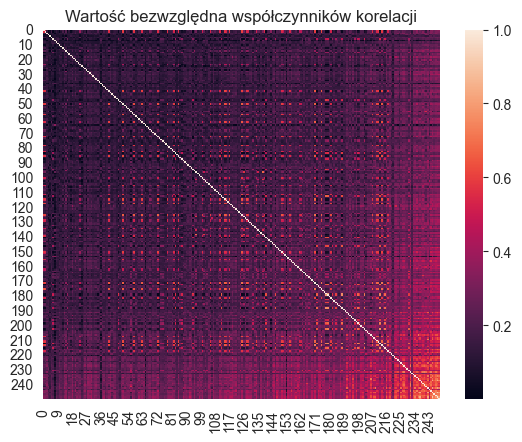

In [56]:
correlation = []
for col1 in columns:
  for col2 in columns:
    spearman = spearmanr(xtrain[col1], xtrain[col2])  # Zrobienie testu oraz wyliczanie korelacji
    correlation.append(abs(spearman[0]))

sns.heatmap(np.reshape(correlation, (250, 250))).set(title="Wartość bezwzględna współczynników korelacji")
plt.show()

Powyższy wykres przedstawia stopień korelacji 250 zmiennych najmocniej skorelowanych ze zmienną objaśnianą. Wartości na bokach wykresu ukazją jak mocno dana zmienna jest skorelowana ze zmienną objaśnianą (Im większa liczba, tym większy współczynnik korelacji). Widać, że stopień skorelowania ze zmienną objaśnianą wpływa na wzajemną korelację. Jeśli obie zmienne są mniej skorelowane ze zmienną objaśnianą, to współczynnik korelacji pomiędzy nimi (poza niewielką ilością przypadków) jest niewielki. Natomiast wraz ze wzrostem korelacji ze zmienną objaśniającą choć jednej zmiennej, rośnie też korelacja z innymi zmiennymi, co widać poprzez stopniowe rozjaśnianie się wykresu przy dolnym oraz prawym brzegu. W przypadku, gdy obie zmienne są mocno skorelowane ze zmienną objaśnianą, współczynnik korelacji jest już naprawdę wysoki. Potencjalnie może to oznaczać, że zmienne najmnocniej skorelowane ze zmienną objaśnianą są w dużej mierze wyjaśniane przez te, które skorelowane są mniej.

# ElasticNet

Model ElasticNet tak jak i ridge oraz lasso estymuje współczynniki przy zmiennych w regresji. Funkcja regresji dla ElasticNet jest zmodyfikowaną funkcją dla regresji liniowej. Parametry są dobierane w taki sposób, aby wartość funkcji  $\frac{1}{2n} \cdot ||y - Xw||^2_2 + a \cdot ||w||_1 + \frac{1}{2} \cdot  b \cdot ||w||_2^2$, gdzie $\alpha = a + b$ oraz l1_ratio$=\frac{a}{a+b}$ była jak najmniejsza. W skrócie ElasticNet ma wzór taki jak regresja liniowa, na której zastosowano w tym samym momencie kary nakładane zarówno w ridge jak i w lasso. Zależnie od wielkości hiperparametrów $\alpha$ oraz l1_ratio może być bardziej nakładana kara z ridge lub lasso. Aby otrzymać samą regresję lasso, l1_ratio=$1$ (ponieważ wtedy $b = 0$, $a=\alpha$), a $\alpha$=wartość współczynnika $\lambda$ dla lasso regression. Natomiast aby otrzymać samą regresję ridge, l1_ratio=$0$ (ponieważ wtedy a=0, $b=\alpha$), a $\alpha$=wartość współczynnika $\lambda$ dla lasso regression. Dla $a=b=0$ funkcja ElasticNet nie działa. Gdyby jednak działał, to zachowywałaby się dokładnie jak liniowa regresja.

Przed skorzystaniem z ElasticNet należy przeskalować oraz wycentrować dane:

In [23]:
scaler = StandardScaler()
xtrain_s = scaler.fit_transform(xtrain)

Stworzę wstępną siatkę hiperparametrów. Dla l1_ratio = 0 model odpowiada regresji ridge, a dla l1_ratio = 1 lasso z parametrem równym odpowiednim $\alpha$. Do walidacji krzyżowej uznałem, że najlepiej dzielić 10-krotnie, ponieważ przy wyższych wartościach parametru cv siatka obliczała się dość długo, a jednak przy większych danych lepiej sprawdzają się większe wartości cv. Uważam, że 90% danych, to dobra wielkość zbioru treningowego.

In [24]:
params = {'alpha': [0.1, 0.4, 0.8, 2.0, 6.0, 10],
          'l1_ratio': [0.0, 0.1, 0.35, 0.65, 0.9, 1.0]}

grid_net_1 = GridSearchCV(estimator=ElasticNet(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
grid_net_1.fit(xtrain_s, ytrain)

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.4, 0.8, 2.0, 6.0, 10],
                         'l1_ratio': [0.0, 0.1, 0.35, 0.65, 0.9, 1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [25]:
print("Najlepsze RMSE ElasticNet (Grid 1):", grid_net_1.best_score_)
print("Najlepsze parametry ElasticNet: (Grid 1)", grid_net_1.best_params_)

Najlepsze RMSE ElasticNet (Grid 1): -0.3424659934205458
Najlepsze parametry ElasticNet: (Grid 1) {'alpha': 0.1, 'l1_ratio': 0.1}


Najlepszy model wyszedł dla $\alpha$ = 0.1 oraz l1_ratio = 0.1, ponieważ wartość ujemnego RMSE jest największa. Przyjrzyjmy się wartościom RMSE w zależności od alf, tworząc wykres dla każdego l_1ratio.

In [18]:
res = pd.DataFrame(grid_net_1.cv_results_)
for l1 in [0.0, 0.1, 0.35, 0.65, 0.9, 1.0]:
  px.scatter(x=res[res['param_l1_ratio'] == l1]['param_alpha'], y=res[res['param_l1_ratio'] == l1]['mean_test_score'], title=("l1_ratio: " + str(l1)), labels={"y": "RMSE", "x": "alfa"}).update_traces(mode="lines+markers").show()

Dla l1_ratio = 0 ekstremum jest w okolicach $\alpha$ = 2, zaś dla pozostałych l1_ratio, widać maksimum lokalne w okolicach $\alpha=0.01$, jednak w obu przpadkach wartości ujemnego RMSE mogą być większe dla odpowiednich wartości $\alpha$. Stąd sporządzę dodatkowe sieci parametrów, by dokładniej zbadać te okolice.

Dla l1_ratio $\neq$ 0 sprawdzę wartości $\alpha$ bliskie 0.01.

In [19]:
params = {'alpha': [0.008, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.12, 0.15],
          'l1_ratio': [0.1, 0.35, 0.65, 0.9, 1.0]}

grid_net_2 = GridSearchCV(estimator=ElasticNet(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
grid_net_2.fit(xtrain_s, ytrain)

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.008, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1,
                                   0.12, 0.15],
                         'l1_ratio': [0.1, 0.35, 0.65, 0.9, 1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [20]:
print("Najlepsze RMSE ElasticNet (Grid 2):", grid_net_2.best_score_)
print("Najlepsze parametry ElasticNet: (Grid 2)", grid_net_2.best_params_)

Najlepsze RMSE ElasticNet (Grid 2): -0.3424659934205458
Najlepsze parametry ElasticNet: (Grid 2) {'alpha': 0.1, 'l1_ratio': 0.1}


Pomimo dokładnego sprawdzenia okolic $\alpha = 0.1$, najlepszy model z poprzedniej siatki wciąż wydaje się być poprawnym wyborem. Zobaczmy to na wykresach: 

In [21]:
res = pd.DataFrame(grid_net_2.cv_results_)
for l1 in [0.1, 0.35, 0.65, 0.9, 1.0]:
  px.scatter(x=res[res['param_l1_ratio'] == l1]['param_alpha'], y=res[res['param_l1_ratio'] == l1]['mean_test_score'], title=("l1_ratio: " + str(l1)), labels={"y": "RMSE", "x": "alfa"}).update_traces(mode="lines+markers").show()

Widać, że dla każdego l1_ratio wartości RMSE osiągają w pewnym momencie maksimum lokalne, a potem zaczynają maleć. Stąd można uznać, że najlepsze RMSE wychodzi dla l1_ratio = 0.1 oraz $\alpha=0.1$, pomimo, że inne modele uzyskały niewiele gorsze wyniki. Jednak to nie koniec badania modeli ElasticNet.

Dla l1_ratio = 0 warto sprawdzić wartości na przedziale $2 \leq α \leq 6$.

In [22]:
params = {'alpha': [2, 2.5, 2.75, 3, 3.5, 4, 4.5, 5, 5.5, 6.0],
          'l1_ratio': [0.0]}

grid_net_3 = GridSearchCV(estimator=ElasticNet(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
grid_net_3.fit(xtrain_s, ytrain)

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [2, 2.5, 2.75, 3, 3.5, 4, 4.5, 5, 5.5, 6.0],
                         'l1_ratio': [0.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [23]:
res = pd.DataFrame(grid_net_3.cv_results_)
px.scatter(x=res[res['param_l1_ratio'] == 0.0]['param_alpha'], y=res[res['param_l1_ratio'] == 0.0]['mean_test_score'], title="l1_ratio: 0.0", labels={"y": "RMSE", "x": "alfa"}).update_traces(mode="lines+markers").show()

In [24]:
print("Najlepsze parametry ElasticNet: (Grid 3)", grid_net_3.best_params_)
print("Najlepsze RMSE ElasticNet (Grid 3):", grid_net_3.best_score_)
print("Najlepsze RMSE ElasticNet: (Dotychczas - zarówno Grid 1 jak i 2)", grid_net_1.best_score_)

Najlepsze parametry ElasticNet: (Grid 3) {'alpha': 2.75, 'l1_ratio': 0.0}
Najlepsze RMSE ElasticNet (Grid 3): -0.3465653634068907
Najlepsze RMSE ElasticNet: (Dotychczas - zarówno Grid 1 jak i 2) -0.3424659934205458


Zarówno z wykresu jak i powyższego kodu widać, że wciąż błąd wychodzi najmniejszy dla modelu, który wyszedł najlepiej już dzięki pierwszej siatce! Jednak powyższe sprawdzenia jedynie pomogły nam się utwierdzić w tym przekonaniu. Stąd parametry najlepszego modelu to:

In [25]:
print("Najlepsze parametry dla ElasticNet:", grid_net_1.best_params_)

Najlepsze parametry dla ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}


In [26]:
print("Liczba wyrzuconych przez model ElasticNet zmiennych:", np.count_nonzero(grid_net_1.best_estimator_.coef_ == 0))

Liczba wyrzuconych przez model ElasticNet zmiennych: 8401


Najlepszy model ElasticNet zeruje wartość współczynnika, aż przy 8401 zmiennych. Oznacza to, że zmiennych znaczących jest niewiele, bo wyłącznie około 600 (1/15 wszystkich zmiennych).

### Błędy modelu z najlepszymi hiperparametrami:

In [27]:
res = pd.DataFrame(grid_net_1.cv_results_)
print("Średni błąd treningowy modelu:", res[res['params'] == {'alpha': 0.1, 'l1_ratio': 0.1}]['mean_train_score'].iloc[0])
print("Średni błąd walidacyjny modelu:", res[res['params'] == {'alpha': 0.1, 'l1_ratio': 0.1}]['mean_test_score'].iloc[0])

Średni błąd treningowy modelu: -0.2857133904414322
Średni błąd walidacyjny modelu: -0.3424659934205458


# Lasy losowe

Zdecydowałem się na wzięcie hiperparametrów "n_estimators" - liczba drzewie trenowanych w lesie, "max_depth" - maksymalna głębokość drzewa oraz "max_featrues" - ilość zmiennych branych do tworzenia drzewa. Funkcja "GridSearchCV" zachowuje takie same podziały danych przy walidacji krzyżowej, jak w przypadku ElasticNet.

In [28]:
params = {'n_estimators': [300, 500, 1000],
          'max_depth': [30, 60, 150, 300],
          'max_features': ["sqrt", 300, 700, 1500]}
forest_grid_1 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
forest_grid_1.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 60, 150, 300],
                         'max_features': ['sqrt', 300, 700, 1500],
                         'n_estimators': [300, 500, 1000]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [29]:
print("Najlepsze parametry Forest: ", forest_grid_1.best_params_)
print("Najlepsze RMSE Forest:", forest_grid_1.best_score_)

Najlepsze parametry Forest:  {'max_depth': 30, 'max_features': 1500, 'n_estimators': 1000}
Najlepsze RMSE Forest: -0.32204447771172806


Obejrzyjmy wykresy: (Są 3D - można obracać)

In [30]:
res = pd.DataFrame(forest_grid_1.cv_results_)
for depth in [30, 60, 150, 300]:
    px.scatter_3d(x = res[res['param_max_depth'] == depth]['param_max_features'], y = res[res['param_max_depth'] == depth]['param_n_estimators'], z = res[res['param_max_depth'] == depth]['mean_test_score'], labels={"x": "number of features", "y": "number of trees", "z": "RMSE"}, title="Tree depth: " + str(depth) ).show()

Bez większego względu na maksymalną głębokość drzewa, dla danych wartości pozostałych hiperparametrów RMSE nie różniło się tak bardzo od siebie. Głębokie drzewa mogą precyzyjniej dobierać wartości, jednak jest szansa, że mogą się dość dopasowywać do danych. Skoro większość RMSE w modelach wychodzi podobna (mimo tego do mniej głębszych lasów lepsza), ale głębokie drzewa mogą się bardziej dopasowywać i obliczają się dłużej, to kolejny grid zrobię na drzewach płytszych. Ilość drzew, które są trenowane w jednym lesie mniejznacząco wpływa na wynik, jednak wartości średnie wychodzą wciąż najlepiej. Na wykresach widać, że główny wpływ na wartość RMSE ma ilość zmiennych brana pod uwagę tworząc jedno drzewo. Wydaje się być to rozsądnym wynikiem. Można by przypuszczać, że im więcej zmiennych nasz model będzie brał, tym bardziej będzie się dopasowywał do zbioru treningowego. Mając jednak w pamięci wyniki modelu ElasticNet (gdzie wyłącznie 1/15 zmiennych była znacząca), można zauważyć, że lasy losowe mogą często brać dużo zmiennych niekoniecznie przydatnych, przez co wyniki dopiero dla większych zbiorów są miarodajne.

Stąd wybierając kolejną siatkę hiperparametrów zmniejszę trochę wartości głębokości, a spróbuję zwiększyć liczbę zmiennych branych pod uwagę przy tworzeniu drzewa.

In [31]:
params = {'n_estimators': [500, 700],
          'max_depth': [30, 45, 60],
          'max_features': [1500, 1750, 2000, 2250]}
forest_grid_2 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
forest_grid_2.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 45, 60],
                         'max_features': [1500, 1750, 2000, 2250],
                         'n_estimators': [500, 700]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [32]:
print("Najlepsze parametry Forest: ", forest_grid_2.best_params_)
print("Najlepsze RMSE Forest:", forest_grid_2.best_score_)

Najlepsze parametry Forest:  {'max_depth': 30, 'max_features': 1500, 'n_estimators': 700}
Najlepsze RMSE Forest: -0.32209528345894906


Nowo wytrenowany model, dał trochę, lecz niewiele gorszy wynik. Obejrzyjmy zatem wykresy:

In [33]:
res = pd.DataFrame(forest_grid_2.cv_results_)
for depth in [30, 45, 60]:
    px.scatter_3d(x = res[res['param_max_depth'] == depth]['param_max_features'], y = res[res['param_max_depth'] == depth]['param_n_estimators'], z = res[res['param_max_depth'] == depth]['mean_test_score'], labels={"x": "number of features", "y": "number of trees", "z": "RMSE"}, title="Tree depth: " + str(depth) ).show()

Głębokość drzew 30, wciąż dla każdej liczby drzew oraz zmiennych ma najlepsze wyniki. Stąd już tylko dla takiej głębokości skonstruuję kolejną siatkę. Najbardziej optymalna liczba zmiennych na każdym wykresie oscyluje w okolicach 1500, więc trochę dokładniej potestuje te okolice.

In [43]:
params = {'n_estimators': [400, 500, 600],
          'max_depth': [30],
          'max_features': [1400, 1600]}
forest_grid_3 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
forest_grid_3.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30], 'max_features': [1400, 1600],
                         'n_estimators': [400, 500, 600]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [49]:
print("Najlepsze parametry Forest: ", forest_grid_3.best_params_)
print("Najlepsze RMSE Forest:", forest_grid_3.best_score_)

Najlepsze parametry Forest:  {'max_depth': 30, 'max_features': 1600, 'n_estimators': 500}
Najlepsze RMSE Forest: -0.32192524752315166


Otrzymane RMSE jest najlepsze dotychczas. Zobaczmy wykres:

In [95]:
res = pd.DataFrame(forest_grid_3.cv_results_)
for depth in [30]:
    px.scatter_3d(x = res[res['param_max_depth'] == depth]['param_max_features'], y = res[res['param_max_depth'] == depth]['param_n_estimators'], z = res[res['param_max_depth'] == depth]['mean_test_score'], labels={"x": "number of features", "y": "number of trees", "z": "RMSE"}, title="Tree depth: " + str(depth) ).show()

Widać, że dobrane hiperparametry są już dość optymalne. Uznam ten model za najlepszy. Wytrenujmy model referencyjny:

In [59]:
params = {'strategy': ['mean']}
r_model = GridSearchCV(estimator=DummyRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
r_model.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'strategy': ['mean']}, return_train_score=True,
             scoring='neg_root_mean_squared_error')

Oraz porównajmy najlepsze modele wraz z referencyjnym.

In [82]:
res_g = pd.DataFrame(grid_net_1.cv_results_)
res_f = pd.DataFrame(forest_grid_3.cv_results_)
res_r = pd.DataFrame(r_model.cv_results_)


print("Model       |      ", "Średni błąd treningowy       |", "      Średni błąd walidacyjny")
print("---------------------------------------------------------------------------------")
print("ElasticNet         ", res_g[res_g['params'] == {'alpha': 0.1, 'l1_ratio': 0.1}]['mean_train_score'].iloc[0], "                  ", res_g[res_g['params'] == {'alpha': 0.1, 'l1_ratio': 0.1}]['mean_test_score'].iloc[0])
print("Lasy losowe        ", res_f[res_f['params'] == {'max_depth': 30, 'max_features': 1600, 'n_estimators': 500}]['mean_train_score'].iloc[0], "                 ", res_f[res_f['params'] == {'max_depth': 30, 'max_features': 1600, 'n_estimators': 500}]['mean_test_score'].iloc[0])
print("Model referencyjny ", res_r['mean_train_score'].iloc[0], "                  ", res_r['mean_test_score'].iloc[0])

Model       |       Średni błąd treningowy       |       Średni błąd walidacyjny
---------------------------------------------------------------------------------
ElasticNet          -0.2857133904414322                    -0.3424659934205458
Lasy losowe         -0.12445437577123475                   -0.32192524752315166
Model referencyjny  -0.7700627073199984                    -0.7700439286066998


Najlepszym modelem zdecydowanie są lasy losowe, ponieważ ich RMSE wyszło najmniejsze. ElasticNet jest niedużo gorszy, jednak oba modele są o wiele lepsze, niż model referencyjny.  Potencjalnie lasy losowe mogą być lepsze, ponieważ są dokładniejsze (przez to też mniej interpretowalne), dane biologiczne są trudne do skalowania, którego lasy losowe nie potrzebują w przeciwieństwie do ElasticNet. 

# Zadanie 4

Z racji, że dane biologiczne ciężko wyskalować, to do stworzenia najlepszego modelu skorzystam z lasów losowych, które go nie potrzebują. Jednak ElasticNet wykazał, że jest dużo zmiennych, które niekoniecznie są potrzebne, więc pozbędę się tych, które zostały wyzerowane w najlepszym modelu ElasticNet z poprzedniego zadania.

In [27]:
temp_x = []
for i in range(len(grid_net_1.best_estimator_.coef_)):
    if (grid_net_1.best_estimator_.coef_[i] != 0):
        temp_x.append(i)
cols = xtrain.columns
temp_cols = []
for el in temp_x:
    temp_cols.append(cols[el])
temp_xtrain = xtrain[temp_cols]

In [28]:
print(temp_xtrain.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 599 entries, HES4 to MT-CYB
dtypes: float64(599)
memory usage: 17.3 MB
None


Po usunięciu zostało tylk 599 zmiennych. Wytrenujmy na nich pierwszy las.

In [47]:
params = {'n_estimators': [300, 600, 1000],
          'max_depth': [30, 60, 100],
          'max_features': ["sqrt", 100, 200]}
forest_grid_4 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
forest_grid_4.fit(temp_xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 60, 100],
                         'max_features': ['sqrt', 100, 200],
                         'n_estimators': [300, 600, 1000]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [50]:
print("Najlepsze parametry Forest: ", forest_grid_4.best_params_)
print("Najlepsze RMSE Forest:", forest_grid_4.best_score_)

Najlepsze parametry Forest:  {'max_depth': 30, 'max_features': 100, 'n_estimators': 1000}
Najlepsze RMSE Forest: -0.3147773253627434


Wyszło lepsze RMSE, niż przy lasach na wszystkich zmiennych. Zobaczmy wykresy:

In [52]:
res = pd.DataFrame(forest_grid_4.cv_results_)
for depth in [30, 60, 100]:
    px.scatter_3d(x = res[res['param_max_depth'] == depth]['param_max_features'], y = res[res['param_max_depth'] == depth]['param_n_estimators'], z = res[res['param_max_depth'] == depth]['mean_test_score'], labels={"x": "number of features", "y": "number of trees", "z": "RMSE"}, title="Tree depth: " + str(depth) ).show()

Dla każdej głębokości wyszły podobne wyniki, jednak ponownie dla 30 najlepsze. Funkcje dla każdej liczby zmiennych są rosnące względem wzrostu drzew. Spróbujmy potestować dla większych lasów.

In [31]:
params = {'n_estimators': [1200, 1400],
          'max_depth': [30],
          'max_features': [100, 150]}
forest_grid_final = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
forest_grid_final.fit(temp_xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30], 'max_features': [100, 150],
                         'n_estimators': [1200, 1400]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [32]:
print("Najlepsze parametry Forest: ", forest_grid_final.best_params_)
print("Najlepsze RMSE Forest:", forest_grid_final.best_score_)

Najlepsze parametry Forest:  {'max_depth': 30, 'max_features': 100, 'n_estimators': 1200}
Najlepsze RMSE Forest: -0.3143815844779147


Najlepsze RMSE wyszło dla powyższych parametrów. Został odrzucony las wielkości 1400, więc powyższy model uznam za najlepszy i wytrenuję na nim xtest. Zacznijmy od transformacji xtest.

In [35]:
temp_x_test = []
for i in range(len(grid_net_1.best_estimator_.coef_)):
    if (grid_net_1.best_estimator_.coef_[i] != 0):
        temp_x_test.append(i)
cols = xtest.columns
temp_cols = []
for el in temp_x_test:
    temp_cols.append(cols[el])
temp_xtest = xtest[temp_cols]

Trenowanie:

In [36]:
model = RandomForestRegressor(max_depth=30, max_features=100, n_estimators=1200)
model.fit(temp_xtrain, ytrain)

RandomForestRegressor(max_depth=30, max_features=100, n_estimators=1200)

Zapisywanie do pliku:

In [40]:
results = pd.DataFrame({'Id': range(1, len(temp_xtest) + 1), 'Expected': model.predict(temp_xtest)})
results.to_csv('448431_predykcja.csv', index=False)